In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Telco_Customer_Churn_Dataset .csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
def clean_data(df):
    df.replace(" ", np.nan, inplace=True)
    df.dropna(inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

In [ ]:
df = clean_data(df)

In [ ]:
df.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0        5365       0              0        1           0       1   
1        3953       1              0        0           0      34   
2        2558       1              0        0           0       2   
3        5524       1              0        0           0      45   
4        6500       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2           29.85          2504      0  
1                 0              3           56.95          1465      0  
2                 1              3           53.85           156      1  
3                 0              0           42.30          1399      0  
4                 1              2           70.70           924      1  

[5 rows x 21 columns]

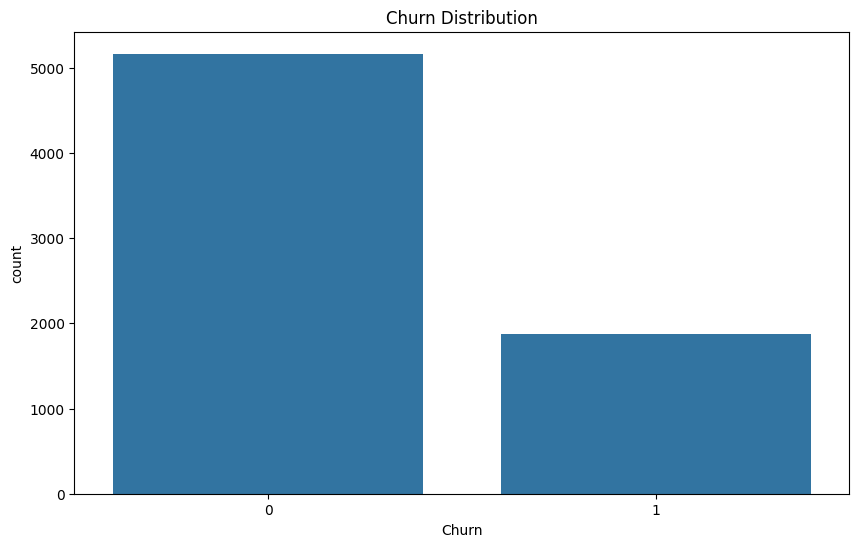

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

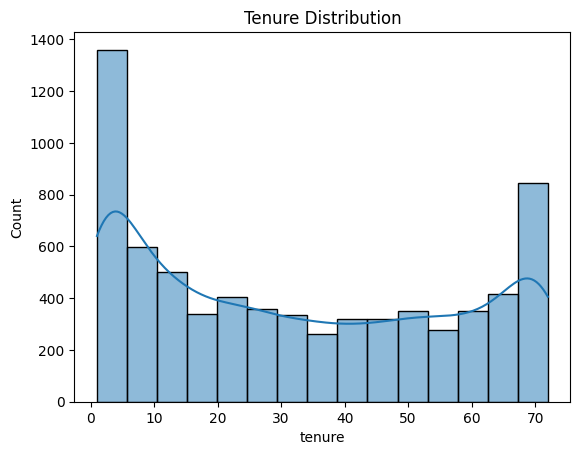

In [ ]:
sns.histplot(df['tenure'], kde=True)
plt.title('Tenure Distribution')
plt.show()

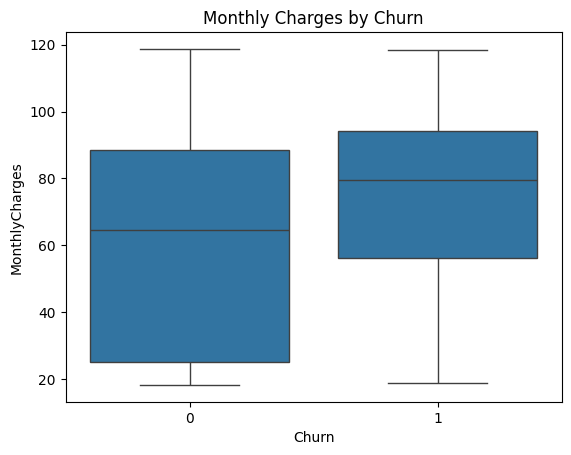

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges by Churn')
plt.show()

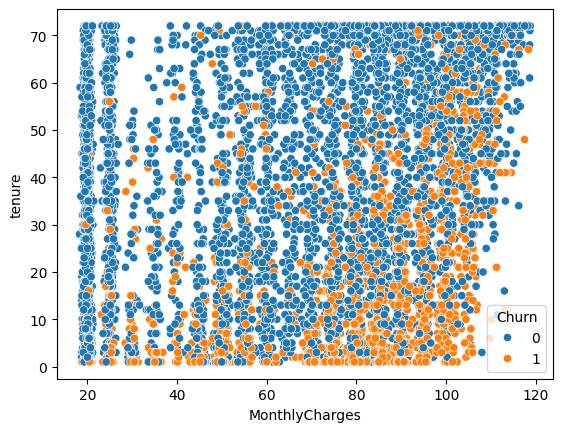

In [ ]:
sns.scatterplot(x='MonthlyCharges', y='tenure', hue='Churn', data=df)
plt.show()

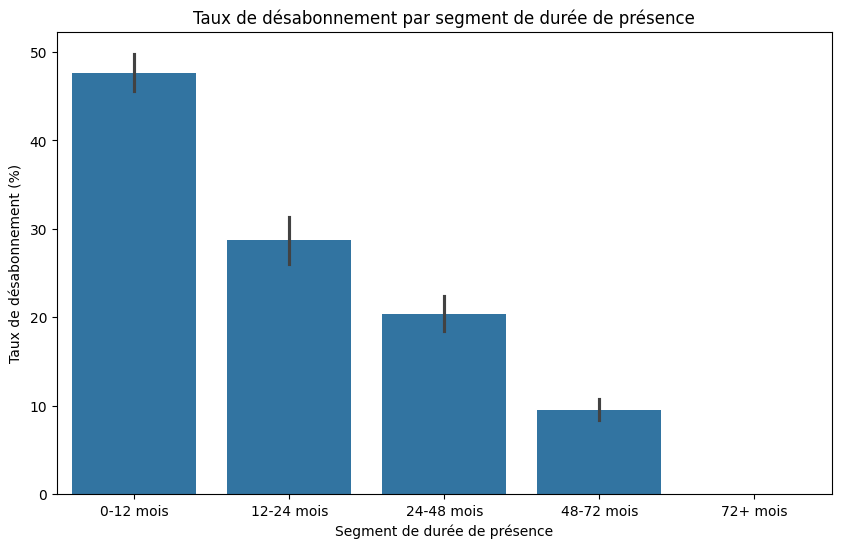

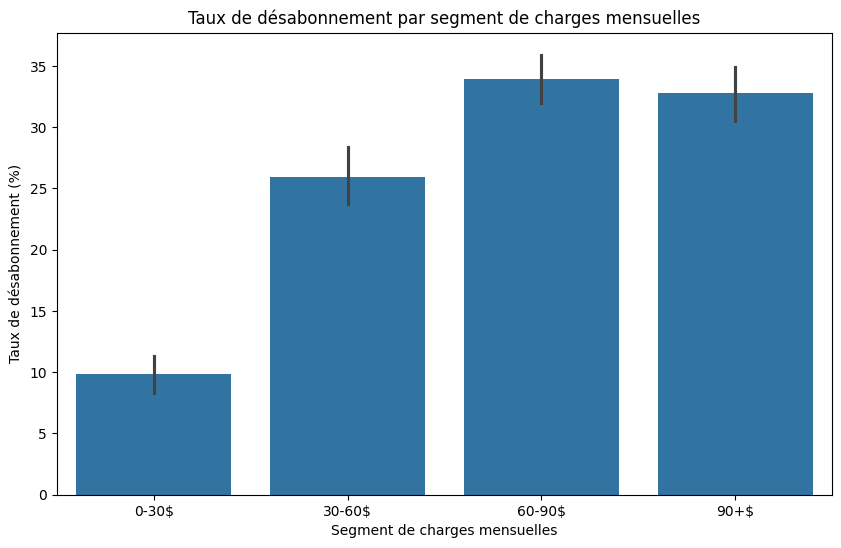

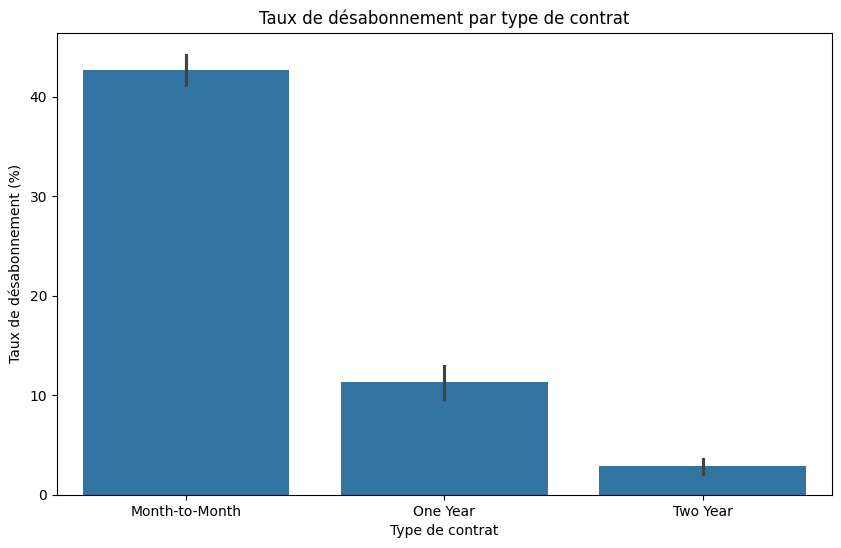

In [ ]:
# Segmentation des clients
# Créer des segments basés sur la durée de présence (tenure)
df['TenureSegment'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72, float('inf')],
                             labels=['0-12 mois', '12-24 mois', '24-48 mois', '48-72 mois', '72+ mois'])

# Créer des segments basés sur les charges mensuelles (MonthlyCharges)
df['MonthlyChargesSegment'] = pd.cut(df['MonthlyCharges'], bins=[0, 30, 60, 90, float('inf')],
                                    labels=['0-30$', '30-60$', '60-90$', '90+$'])

# Créer des segments basés sur le type de contrat (Contract)
df['ContractSegment'] = df['Contract'].map({0: 'Month-to-Month', 1: 'One Year', 2: 'Two Year'})

# Analyser les taux de désabonnement par segment
# Taux de désabonnement par segment de durée de présence
plt.figure(figsize=(10, 6))
sns.barplot(x='TenureSegment', y='Churn', data=df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Taux de désabonnement par segment de durée de présence')
plt.ylabel('Taux de désabonnement (%)')
plt.xlabel('Segment de durée de présence')
plt.show()

# Taux de désabonnement par segment de charges mensuelles
plt.figure(figsize=(10, 6))
sns.barplot(x='MonthlyChargesSegment', y='Churn', data=df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Taux de désabonnement par segment de charges mensuelles')
plt.ylabel('Taux de désabonnement (%)')
plt.xlabel('Segment de charges mensuelles')
plt.show()

# Taux de désabonnement par type de contrat
plt.figure(figsize=(10, 6))
sns.barplot(x='ContractSegment', y='Churn', data=df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Taux de désabonnement par type de contrat')
plt.ylabel('Taux de désabonnement (%)')
plt.xlabel('Type de contrat')
plt.show()

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

In [ ]:
predictions_lr = model_lr.predict(X_test)
predictions_rf = model_rf.predict(X_test)

In [ ]:
# Évaluation des modèles avec plus de métriques
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- Évaluation du modèle : {model_name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision : {precision_score(y_true, y_pred):.2f}")
    print(f"Recall : {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.2f}")
    print("\nClassification Report :\n", classification_report(y_true, y_pred))
    print("\nMatrice de Confusion :\n", confusion_matrix(y_true, y_pred))
    print("\n------------------------------------------------\n")

In [ ]:
# Évaluation de la régression logistique
evaluate_model(y_test, predictions_lr, "Régression Logistique")

--- Évaluation du modèle : Régression Logistique ---
Accuracy : 0.79
Precision : 0.62
Recall : 0.49
F1 Score : 0.55

Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407


Matrice de Confusion :
 [[922 111]
 [190 184]]

------------------------------------------------



In [ ]:
# Évaluation de la forêt aléatoire
evaluate_model(y_test, predictions_rf, "Forêt Aléatoire")

--- Évaluation du modèle : Forêt Aléatoire ---
Accuracy : 0.79
Precision : 0.66
Recall : 0.47
F1 Score : 0.55

Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.47      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Matrice de Confusion :
 [[941  92]
 [199 175]]

------------------------------------------------



In [ ]:
# Courbe ROC pour visualiser les performances sur les classes déséquilibrées
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_lr.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])

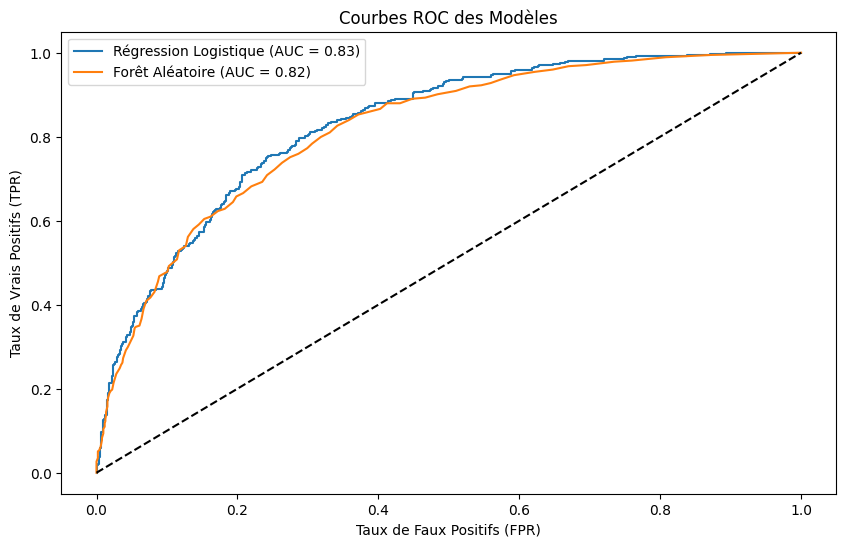

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='Régression Logistique (AUC = {:.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.plot(fpr_rf, tpr_rf, label='Forêt Aléatoire (AUC = {:.2f})'.format(auc(fpr_rf, tpr_rf)))
plt.plot([0, 1], [0, 1], 'k--')  # Courbe de base (modèle aléatoire)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC des Modèles')
plt.legend()
plt.show()


In [ ]:
# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Réentraînement des modèles avec SMOTE et recherche d'hyperparamètres

# Régression Logistique avec class_weight
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}  # Ajustement de la régularisation
grid_lr = GridSearchCV(model_lr, param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_resampled, y_resampled)

# Random Forest avec class_weight et recherche d'hyperparamètres
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None]
}
grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(X_resampled, y_resampled)

# Prédictions avec les meilleurs modèles
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

predictions_lr = best_lr.predict(X_test)
predictions_rf = best_rf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# Évaluation de la régression logistique
evaluate_model(y_test, predictions_lr, "Régression Logistique")

--- Évaluation du modèle : Régression Logistique ---
Accuracy : 0.75
Precision : 0.52
Recall : 0.71
F1 Score : 0.60

Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1033
           1       0.52      0.71      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407


Matrice de Confusion :
 [[785 248]
 [110 264]]

------------------------------------------------



In [ ]:
# Évaluation de la forêt aléatoire
evaluate_model(y_test, predictions_rf, "Forêt Aléatoire")

--- Évaluation du modèle : Forêt Aléatoire ---
Accuracy : 0.99
Precision : 0.97
Recall : 1.00
F1 Score : 0.99

Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1033
           1       0.97      1.00      0.99       374

    accuracy                           0.99      1407
   macro avg       0.99      1.00      0.99      1407
weighted avg       0.99      0.99      0.99      1407


Matrice de Confusion :
 [[1023   10]
 [   0  374]]

------------------------------------------------



In [ ]:
# Courbe ROC pour visualiser les performances sur les classes déséquilibrées
fpr_lr, tpr_lr, _ = roc_curve(y_test, best_lr.predict_proba(X_test)[:, 1]) # Changed model_lr to best_lr
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1]) # Changed model_rf to best_rf

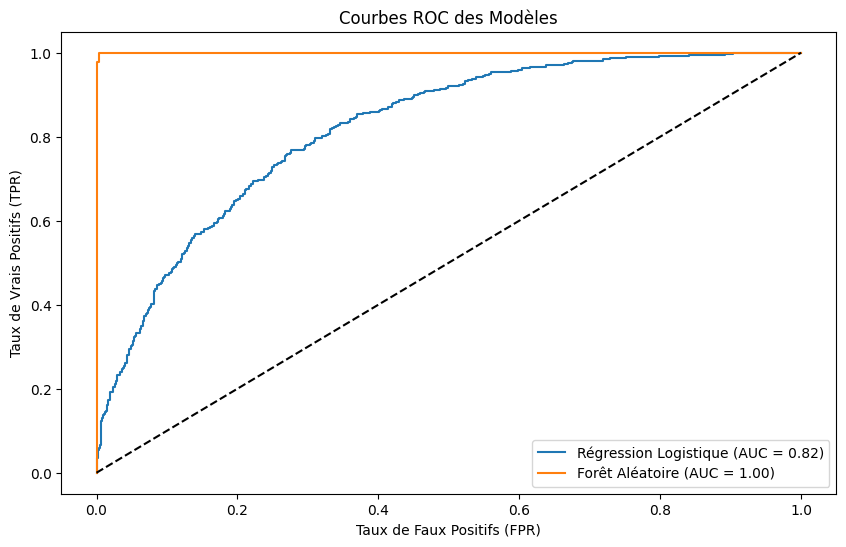

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='Régression Logistique (AUC = {:.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.plot(fpr_rf, tpr_rf, label='Forêt Aléatoire (AUC = {:.2f})'.format(auc(fpr_rf, tpr_rf)))
plt.plot([0, 1], [0, 1], 'k--')  # Courbe de base (modèle aléatoire)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC des Modèles')
plt.legend()
plt.show()


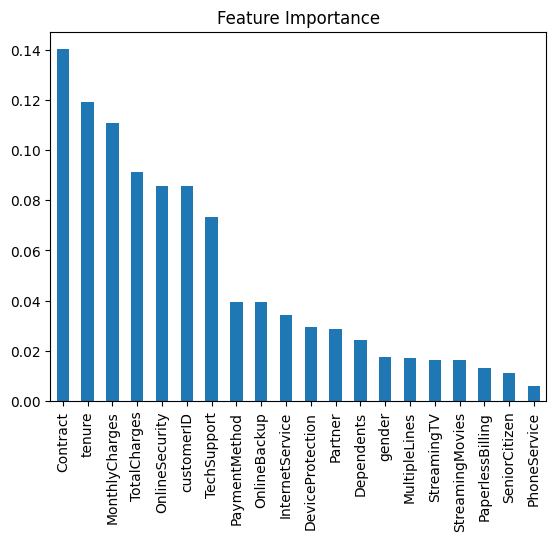

In [ ]:
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

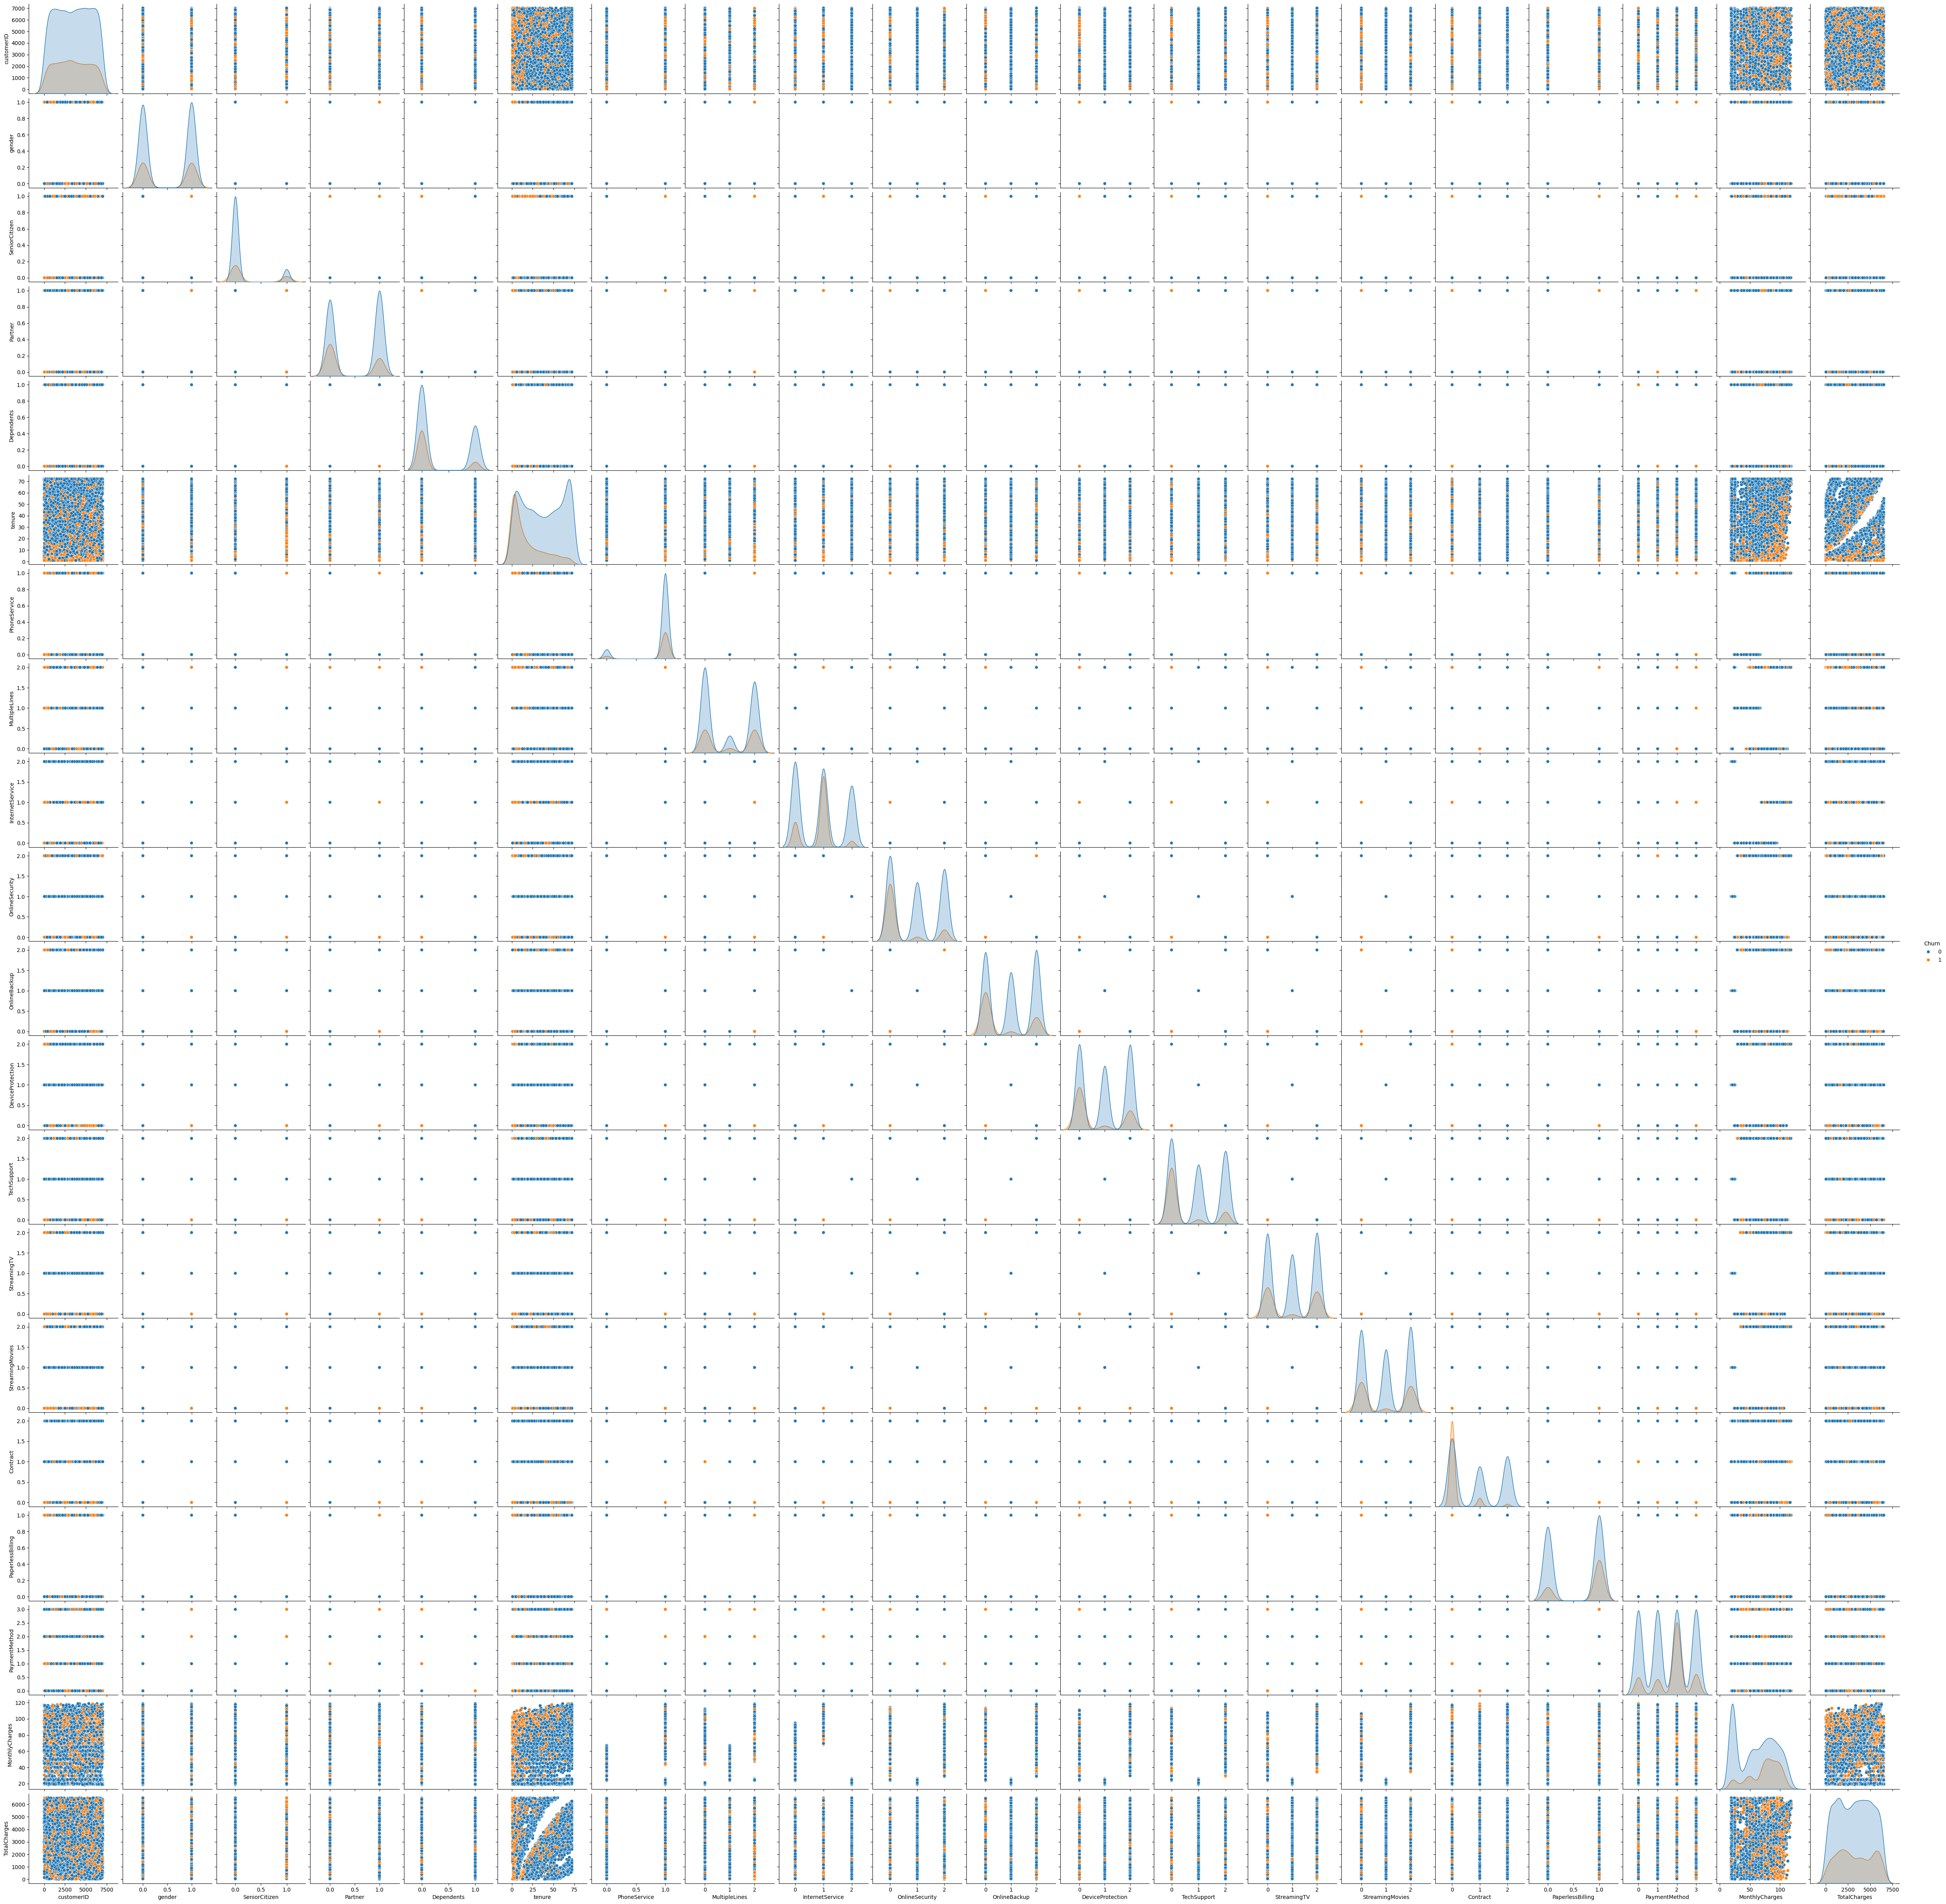

In [ ]:
sns.pairplot(df, hue='Churn')
plt.show()

In [ ]:
# Calculer la valeur à vie (LTV) des clients
# Supposons que la valeur moyenne mensuelle d'un client est égale à MonthlyCharges
df['LTV'] = df['tenure'] * df['MonthlyCharges']

# Identifier les clients à haut risque de désabonnement et à haute valeur
df['HighRiskHighValue'] = (df['Churn'] == 1) & (df['LTV'] > df['LTV'].quantile(0.75))

# Afficher les clients à haut risque de désabonnement et à haute valeur
high_risk_high_value_customers = df[df['HighRiskHighValue']]
print("Clients à haut risque de désabonnement et à haute valeur :")
print(high_risk_high_value_customers[['customerID', 'tenure', 'MonthlyCharges', 'LTV', 'Churn']].head())

# Proposer des stratégies de rétention
# Exemple de stratégies basées sur les insights
print("\nStratégies de rétention proposées :")
print("1. Offrir des incitations aux clients avec un contrat 'Month-to-Month' pour les convertir en contrats plus longs.")
print("2. Cibler les clients avec des charges mensuelles élevées et une durée de présence courte pour des offres personnalisées.")
print("3. Mettre en place des programmes de fidélité pour les clients à haute valeur (LTV élevé).")
print("4. Améliorer le service client pour les clients à haut risque de désabonnement.")

Clients à haut risque de désabonnement et à haute valeur :
     customerID  tenure  MonthlyCharges      LTV  Churn
13          174      49          103.70  5081.30      1
26         4574      47           99.35  4669.45      1
104        2228      68          110.00  7480.00      1
110         327      55           96.75  5321.25      1
173         475      53           94.85  5027.05      1

Stratégies de rétention proposées :
1. Offrir des incitations aux clients avec un contrat 'Month-to-Month' pour les convertir en contrats plus longs.
2. Cibler les clients avec des charges mensuelles élevées et une durée de présence courte pour des offres personnalisées.
3. Mettre en place des programmes de fidélité pour les clients à haute valeur (LTV élevé).
4. Améliorer le service client pour les clients à haut risque de désabonnement.


In [ ]:
# Save the cleaned data
df.to_csv('cleaned_telco_data.csv', index=False)

# Save feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save churn probabilities
df_test_results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_rf, 'Churn Probability': best_rf.predict_proba(X_test)[:, 1]})
df_test_results.to_csv('churn_predictions.csv', index=False)


In [ ]:
def predict_churn_from_example(model,example_data):
    """
    Utilise un exemple de données pour prédire le désabonnement en utilisant le modèle fourni.

    Args:
        model: Modèle de machine learning entraîné (par exemple, best_rf).

    Returns:
        pd.DataFrame: DataFrame contenant les prédictions de désabonnement pour chaque client.
    """

    # Convertir en DataFrame
    new_data = pd.DataFrame(example_data)

    # Prétraitement des données (identique à celui utilisé pour l'entraînement)
    new_data_cleaned = clean_data(new_data)

    # Sélectionner les colonnes nécessaires pour la prédiction
    required_columns = X.columns  # Les colonnes utilisées pour l'entraînement du modèle
    new_data_cleaned = new_data_cleaned[required_columns]

    # Faire des prédictions avec le modèle
    predictions = model.predict(new_data_cleaned)
    probabilities = model.predict_proba(new_data_cleaned)[:, 1]  # Probabilité de désabonnement

    # Ajouter les prédictions et les probabilités au DataFrame
    new_data['Churn_Prediction'] = predictions
    new_data['Churn_Probability'] = probabilities

    return new_data

In [ ]:
# Appeler la fonction pour prédire le désabonnement
 # Exemple de données (remplacez par vos propres données)
example_data = {
        'customerID': ['7590-VHVEG', '5575-GNVDE', '3668-QPYBK'],
        'gender': ['Female', 'Male', 'Male'],
        'SeniorCitizen': [0, 0, 0],
        'Partner': ['Yes', 'No', 'No'],
        'Dependents': ['No', 'No', 'No'],
        'tenure': [1, 34, 2],
        'PhoneService': ['No', 'Yes', 'Yes'],
        'MultipleLines': ['No phone service', 'No', 'No'],
        'InternetService': ['DSL', 'DSL', 'DSL'],
        'OnlineSecurity': ['No', 'Yes', 'Yes'],
        'OnlineBackup': ['Yes', 'No', 'Yes'],
        'DeviceProtection': ['No', 'Yes', 'No'],
        'TechSupport': ['No', 'No', 'No'],
        'StreamingTV': ['No', 'No', 'No'],
        'StreamingMovies': ['No', 'No', 'No'],
        'Contract': ['Month-to-month', 'One year', 'Month-to-month'],
        'PaperlessBilling': ['Yes', 'No', 'Yes'],
        'PaymentMethod': ['Electronic check', 'Mailed check', 'Mailed check'],
        'MonthlyCharges': [29.85, 56.95, 53.85],
        'TotalCharges': [29.85, 1889.5, 108.15]
    }
predictions_df = predict_churn_from_example(best_rf,example_data)

# Afficher les résultats
if predictions_df is not None:
    print("Prédictions de désabonnement :")
    print(predictions_df[['customerID', 'Churn_Prediction', 'Churn_Probability']])

Prédictions de désabonnement :
   customerID  Churn_Prediction  Churn_Probability
0           2                 1           0.691320
1           1                 1           0.529896
2           0                 1           0.926080
